In [3]:
import causalnex
import pandas as pd
import numpy as np

#for splitting, scaling and encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#for pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

#for drawing causal graph and evaluation
from causalnex.structure.notears import from_pandas
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from IPython.display import Image
from causalnex.network import BayesianNetwork
from causalnex.discretiser import Discretiser
from causalnex.discretiser.discretiser_strategy import ( DecisionTreeSupervisedDiscretiserMethod )
from causalnex.evaluation import classification_report,roc_auc

import warnings
import os
import sys
sys.path.append(os.path.abspath(os.path.join('../scripts')))

from pandas import DataFrame
warnings.filterwarnings("ignore")

In [4]:
from causal_learning import CausalLearning

In [5]:
data = pd.read_csv("../data/data2.csv")
data.drop("Unnamed: 0", axis=1, inplace = True)

In [6]:
cl = CausalLearning()
data

,texture_mean,area_mean,smoothness_mean,concavity_mean,fractal_dimension_mean,area_se,smoothness_se,concavity_se,fractal_dimension_se,smoothness_worst,concavity_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,10.38,1001.0,0.11840,0.30010,0.07871,153.40,0.006399,0.05373,0.006193,0.16220,0.7119,0.4601,0.11890,M
1,17.77,1326.0,0.08474,0.08690,0.05667,74.08,0.005225,0.01860,0.003532,0.12380,0.2416,0.2750,0.08902,M
2,21.25,1203.0,0.10960,0.19740,0.05999,94.03,0.006150,0.03832,0.004571,0.14440,0.4504,0.3613,0.08758,M
3,20.38,386.1,0.14250,0.24140,0.09744,27.23,0.009110,0.05661,0.009208,0.20980,0.6869,0.6638,0.17300,M
4,14.34,1297.0,0.10030,0.19800,0.05883,94.44,0.011490,0.05688,0.005115,0.13740,0.4000,0.2364,0.07678,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,22.39,1479.0,0.11100,0.24390,0.05623,158.70,0.010300,0.05198,0.004239,0.14100,0.4107,0.2060,0.07115,M
565,28.25,1261.0,0.09780,0.14400,0.05533,99.04,0.005769,0.03950,0.002498,0.11660,0.3215,0.2572,0.06637,M
566,28.08,858.1,0.08455,0.09251,0.05648,48.55,0.005903,0.04730,0.003892,0.11390,0.3403,0.2218,0.07820,M
567,29.33,1265.0,0.11780,0.35140,0.07016,86.22,0.006522,0.07117,0.006185,0.16500,0.9387,0.4087,0.12400,M


### split data set to training and holdout set and return the training dataset

In [7]:
# a pipeline to process data and gives us the trained datasetset
pipe = Pipeline(steps=[("labeler", FunctionTransformer(cl.labeler, kw_args={'col':'diagnosis'})),
    ("split", FunctionTransformer(cl.splitter, kw_args={'rand':20, 'test':0.2, 'split':'t'})),
                        ("scaler", FunctionTransformer(cl.scaler)),
                        ("rename_col", FunctionTransformer(cl.rename_col, kw_args={'df2':data}))])

In [8]:
train_df = pipe.fit_transform(data)
train_df

(455, 14)


,texture_mean,area_mean,smoothness_mean,concavity_mean,fractal_dimension_mean,area_se,smoothness_se,concavity_se,fractal_dimension_se,smoothness_worst,concavity_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,0.391003,0.053150,0.293907,0.087512,0.401860,0.000000,0.129245,0.094318,0.127420,0.247177,0.149201,0.192682,0.242818,0.0
1,0.549827,1.000000,0.605735,0.851687,0.145814,1.000000,0.201822,0.203409,0.126556,0.426137,0.545767,0.255643,0.126131,1.0
2,0.205882,0.183245,0.435973,0.041050,0.269535,0.019514,0.071897,0.017874,0.027714,0.364723,0.096326,0.294844,0.149416,0.0
3,0.340138,0.227953,0.469643,0.159888,0.174884,0.028088,0.125846,0.054369,0.031687,0.333025,0.135783,0.191019,0.071822,0.0
4,0.469550,0.271135,0.340828,0.232849,0.079535,0.055618,0.273855,0.127551,0.072800,0.276894,0.185463,0.295557,0.051358,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,0.386851,0.460870,0.447486,0.298032,0.136047,0.219646,0.173063,0.087020,0.108833,0.423496,0.288898,0.357567,0.180441,1.0
451,0.341522,0.262057,0.541653,0.268744,0.303953,0.047419,0.103784,0.060202,0.077256,0.554910,0.317572,0.576859,0.336875,1.0
452,0.092042,0.103712,0.496470,0.076500,0.296279,0.011894,0.161777,0.032374,0.066408,0.426798,0.101837,0.277501,0.165158,0.0
453,0.181315,0.091368,0.522103,0.119845,0.428140,0.005220,0.093857,0.069621,0.130495,0.409628,0.268770,0.241388,0.347370,0.0


### causal graph with training dataset

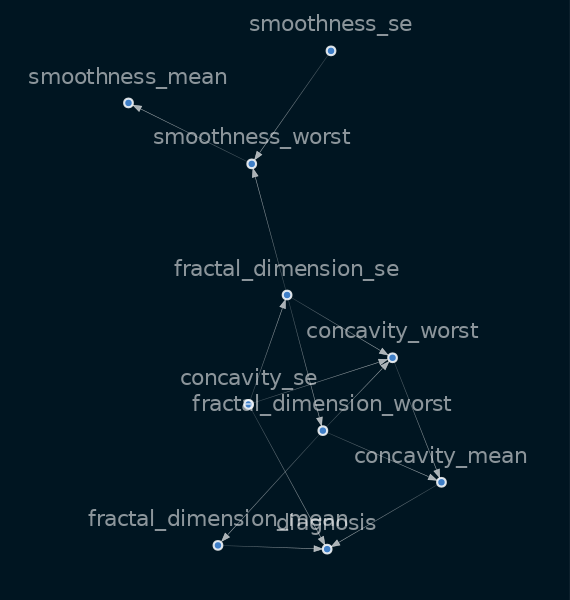

In [9]:
sm = from_pandas(train_df)
sm.remove_edges_below_threshold(0.8)
sm = sm.get_largest_subgraph()

cl.causal_graph(train_df, sm)

### create causal graph by increasing fraction of the data

* 80% of the data

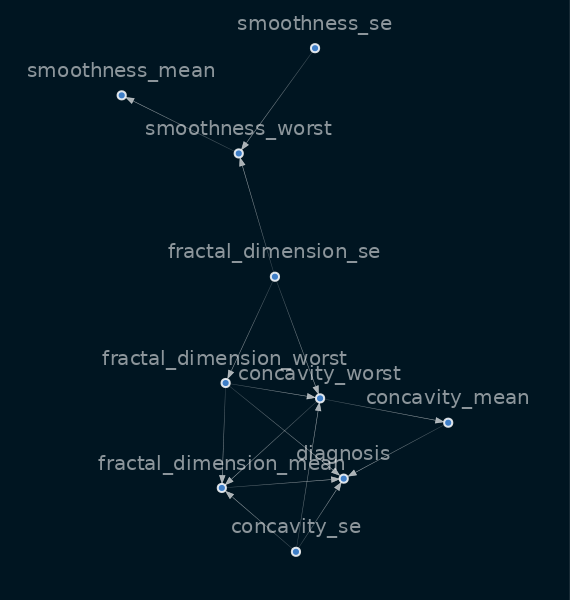

In [10]:
df1 = train_df[:int(len(train_df)*0.8)]

sm1 = from_pandas(df1)
sm1.remove_edges_below_threshold(0.8)
sm1 = sm1.get_largest_subgraph()
cl.causal_graph(df1, sm1)

* 70% of the data

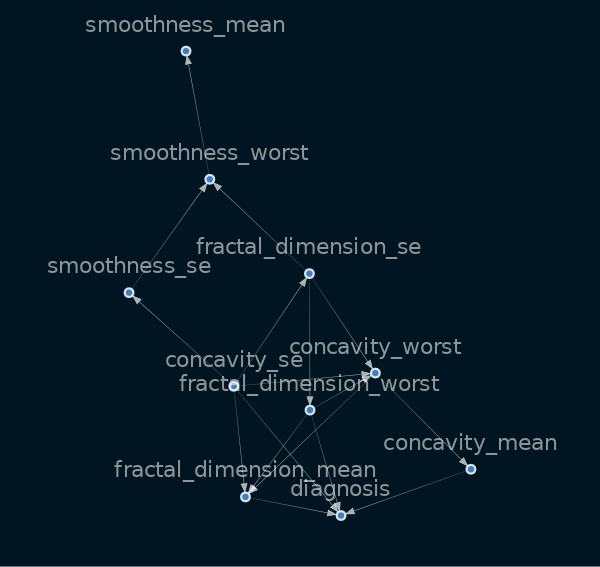

In [11]:
df2 = train_df[:int(len(train_df)*0.7)]

sm2 = from_pandas(df2)
sm2.remove_edges_below_threshold(0.8)
sm2 = sm2.get_largest_subgraph()
cl.causal_graph(df2, sm2)

* 60% of the data

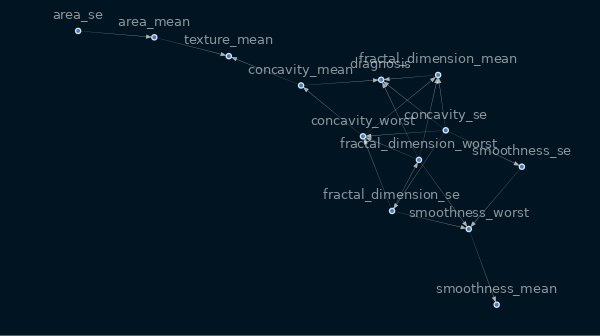

In [12]:
df3 = train_df[:int(len(train_df)*0.6)]

sm3 = from_pandas(df3)
sm3.remove_edges_below_threshold(0.8)
sm3 = sm3.get_largest_subgraph()
cl.causal_graph(df3, sm3)

### ground truth causal graph vs. fractioned causal graph

In [13]:
#100% vs 80%
cl.jaccard_set(sm.edges, sm1.edges)

0.7058823529411765

In [14]:
#100% vs 70%
cl.jaccard_set(sm.edges, sm2.edges)

0.7222222222222222

In [15]:
#100% vs 60%
cl.jaccard_set(sm.edges, sm3.edges)

0.5909090909090909

In [16]:
sm_lis = [sm, sm1, sm2, sm3]
edges = cl.check_edges(sm_lis)

[('fractal_dimension_mean', 'diagnosis'), ('concavity_mean', 'diagnosis'), ('concavity_se', 'diagnosis')]
[('concavity_mean', 'diagnosis'), ('fractal_dimension_worst', 'fractal_dimension_mean'), ('fractal_dimension_worst', 'diagnosis'), ('fractal_dimension_mean', 'diagnosis'), ('concavity_se', 'fractal_dimension_mean'), ('concavity_se', 'diagnosis')]
[('concavity_mean', 'diagnosis'), ('fractal_dimension_worst', 'fractal_dimension_mean'), ('fractal_dimension_worst', 'diagnosis'), ('fractal_dimension_mean', 'diagnosis'), ('concavity_se', 'fractal_dimension_mean'), ('concavity_se', 'diagnosis')]
[('concavity_mean', 'diagnosis'), ('fractal_dimension_worst', 'fractal_dimension_mean'), ('fractal_dimension_worst', 'diagnosis'), ('fractal_dimension_mean', 'diagnosis'), ('concavity_se', 'fractal_dimension_mean'), ('concavity_se', 'diagnosis')]


### selected variables: fractal_dimension_mean, concavity_se, concavity_mean

In [17]:
selected = cl.var_parents(edges)
sel_ft = pd.DataFrame()
sel_ft[selected] = train_df[selected]
sel_ft['diagnosis'] = train_df['diagnosis']

In [18]:
sel_ft

,fractal_dimension_mean,concavity_mean,fractal_dimension_worst,concavity_se,diagnosis
0,0.401860,0.087512,0.242818,0.094318,0.0
1,0.145814,0.851687,0.126131,0.203409,1.0
2,0.269535,0.041050,0.149416,0.017874,0.0
3,0.174884,0.159888,0.071822,0.054369,0.0
4,0.079535,0.232849,0.051358,0.127551,1.0
...,...,...,...,...,...
450,0.136047,0.298032,0.180441,0.087020,1.0
451,0.303953,0.268744,0.336875,0.060202,1.0
452,0.296279,0.076500,0.165158,0.032374,0.0
453,0.428140,0.119845,0.347370,0.069621,0.0


### Train model with all variables

In [19]:
desc_df1= cl.descreter(train_df, train_df.columns.to_list())
desc_df1

,texture_mean,area_mean,smoothness_mean,concavity_mean,fractal_dimension_mean,area_se,smoothness_se,concavity_se,fractal_dimension_se,smoothness_worst,concavity_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,3,0,0,0,3,0,0,2,3,0,0,0,1,0
1,3,3,3,3,2,3,0,2,3,1,3,0,0,1
2,0,1,2,0,2,0,0,0,1,1,0,0,0,0
3,2,1,2,0,2,1,0,2,1,1,0,0,0,0
4,3,2,1,2,1,2,0,2,2,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,3,3,2,3,2,3,0,2,3,1,2,2,1,1
451,2,2,2,2,2,2,0,2,2,2,3,3,3,1
452,0,0,2,0,2,0,0,1,2,1,0,0,1,0
453,0,0,2,0,3,0,0,2,3,1,2,0,3,0


In [20]:
bn = BayesianNetwork(sm)
cl.bayseian(desc_df1, bn)

,texture_mean,area_mean,smoothness_mean,concavity_mean,fractal_dimension_mean,area_se,smoothness_se,concavity_se,fractal_dimension_se,smoothness_worst,concavity_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,3,0,0,0,3,0,0,2,3,0,0,0,1,0
1,3,3,3,3,2,3,0,2,3,1,3,0,0,1
2,0,1,2,0,2,0,0,0,1,1,0,0,0,0
3,2,1,2,0,2,1,0,2,1,1,0,0,0,0
4,3,2,1,2,1,2,0,2,2,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,3,3,2,3,2,3,0,2,3,1,2,2,1,1
451,2,2,2,2,2,2,0,2,2,2,3,3,3,1
452,0,0,2,0,2,0,0,1,2,1,0,0,1,0
453,0,0,2,0,3,0,0,2,3,1,2,0,3,0


In [21]:
bn.cpds["diagnosis"]

concavity_mean            0                                               \
concavity_se              0                                  1             
fractal_dimension_mean    0         1         2         3    0         1   
diagnosis                                                                  
0                       0.5  0.916667  0.985915  0.916667  0.5  0.545455   
1                       0.5  0.083333  0.014085  0.083333  0.5  0.454545   

concavity_mean                                        ...    3             \
concavity_se                             2            ...    1          2   
fractal_dimension_mean         2    3    0         1  ...    2    3     0   
diagnosis                                             ...                   
0                       0.929412  0.9  0.5  0.714286  ...  0.5  0.5  0.25   
1                       0.070588  0.1  0.5  0.285714  ...  0.5  0.5  0.75   

concavity_mean                                                       
concavity_se                                       3                 
fractal_dimension_mean    1         2         3    0    1    2    3  
diagnosis                                                            
0                       0.1  0.034483  0.132075  0.5  0.5  0.5  0.8  
1                       0.9  0.965517  0.867925  0.5  0.5  0.5  0.2  

[2 rows x 64 columns]

In [22]:
# save
import joblib
joblib.dump(bn, "../models/bayseain_all.pkl") 

['../models/bayseain_all.pkl']

### Train model with selcted variables

In [23]:
desc_df2 = cl.descreter(sel_ft, sel_ft.columns.to_list())
desc_df2

,fractal_dimension_mean,concavity_mean,fractal_dimension_worst,concavity_se,diagnosis
0,3,0,1,2,0
1,2,3,0,2,1
2,2,0,0,0,0
3,2,0,0,2,0
4,1,2,0,2,1
...,...,...,...,...,...
450,2,3,1,2,1
451,2,2,3,2,1
452,2,0,1,1,0
453,3,0,3,2,0


In [24]:
sm6 = from_pandas(sel_ft)

sm6.remove_edges_below_threshold(0.8)
sm6 = sm6.get_largest_subgraph()

In [25]:
bn2 = BayesianNetwork(sm6)
cl.bayseian(df=desc_df2, bn=bn2)

,fractal_dimension_mean,concavity_mean,fractal_dimension_worst,concavity_se,diagnosis
0,3,0,1,2,0
1,2,3,0,2,1
2,2,0,0,0,0
3,2,0,0,2,0
4,1,2,0,2,1
...,...,...,...,...,...
450,2,3,1,2,1
451,2,2,3,2,1
452,2,0,1,1,0
453,3,0,3,2,0


In [26]:
bn2.cpds["diagnosis"]

concavity_mean             0                                          \
concavity_se               0                                           
fractal_dimension_mean     0                        1                  
fractal_dimension_worst    0    1    2    3         0    1    2    3   
diagnosis                                                              
0                        0.5  0.5  0.5  0.5  0.916667  0.5  0.5  0.5   
1                        0.5  0.5  0.5  0.5  0.083333  0.5  0.5  0.5   

concavity_mean                               ...    3                      \
concavity_se                                 ...    3                       
fractal_dimension_mean          2            ...    1         2             
fractal_dimension_worst         0         1  ...    2    3    0    1    2   
diagnosis                                    ...                            
0                        0.983051  0.923077  ...  0.5  0.5  0.5  0.5  0.5   
1                        0.016949  0.076923  ...  0.5  0.5  0.5  0.5  0.5   

concavity_mean                                    
concavity_se                                      
fractal_dimension_mean          3                 
fractal_dimension_worst    3    0    1    2    3  
diagnosis                                         
0                        0.5  0.5  0.5  0.5  0.8  
1                        0.5  0.5  0.5  0.5  0.2  

[2 rows x 256 columns]

In [27]:
# save
import joblib

joblib.dump(bn, "../models/bayseain_selected.pkl")

['../models/bayseain_selected.pkl']

### Measure how much each of the models overfit the hold-out set

In [28]:
# a pipeline to process data and gives us the holdout datasetset
pipe2 = Pipeline(steps=[("labeler", FunctionTransformer(cl.labeler, kw_args={'col':'diagnosis'})),
    ("split", FunctionTransformer(cl.splitter, kw_args={'rand':20, 'test':0.2, 'split':'v'})),
                        ("scaler", FunctionTransformer(cl.scaler)),
                        ("rename_col", FunctionTransformer(cl.rename_col, kw_args={'df2':data}))])

In [29]:
holdout_df = pipe2.fit_transform(data)
holdout_df

(114, 14)


,texture_mean,area_mean,smoothness_mean,concavity_mean,fractal_dimension_mean,area_se,smoothness_se,concavity_se,fractal_dimension_se,smoothness_worst,concavity_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,0.576674,0.079089,0.391132,0.250831,0.389277,0.058061,0.320735,0.714606,0.291192,0.393047,0.344997,0.181283,0.243578,0.0
1,0.522138,0.307892,0.062431,0.124970,0.088578,0.064731,0.000000,0.127653,0.000000,0.193382,0.307692,0.197117,0.078906,1.0
2,0.831533,0.490072,0.371277,0.688539,0.248358,0.448343,0.180638,0.505940,0.149431,0.517143,0.834990,0.351604,0.338670,1.0
3,1.000000,0.133068,0.128281,0.120398,0.228650,0.026193,0.237965,0.286368,0.137439,0.292021,0.246562,0.149208,0.198980,0.0
4,0.761339,0.226094,0.241452,0.331057,0.298368,0.105584,0.425148,0.359104,0.159098,0.571235,0.509735,0.611449,0.380718,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,0.592333,0.330126,0.488198,0.511283,0.493961,0.212951,0.221706,0.310419,0.130002,0.754196,0.651327,0.404791,0.482759,1.0
110,0.170626,0.025884,1.000000,0.288895,0.948718,0.054818,0.367240,0.339143,0.423193,0.844086,0.285773,0.269184,0.579521,0.0
111,0.496220,0.134616,0.122656,0.022298,0.216783,0.045462,0.229835,0.056787,0.065489,0.356455,0.061348,0.237109,0.189215,0.0
112,0.696544,0.208174,0.445180,0.631829,0.563043,0.050974,0.190192,0.535638,0.313642,0.644420,0.945269,0.382460,0.736981,1.0


In [30]:
desc_df3= cl.descreter(holdout_df, holdout_df.columns.to_list())
desc_df3

,texture_mean,area_mean,smoothness_mean,concavity_mean,fractal_dimension_mean,area_se,smoothness_se,concavity_se,fractal_dimension_se,smoothness_worst,concavity_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,2,0,3,1,3,0,1,3,1,1,1,1,3,0
1,2,2,0,0,0,0,0,1,0,0,1,1,0,1
2,2,2,3,3,3,3,1,2,1,3,3,2,3,1
3,3,0,0,0,3,0,1,1,1,0,0,0,1,0
4,2,1,3,2,3,1,1,2,1,3,3,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,2,2,3,3,3,3,1,2,1,3,3,3,3,1
110,0,0,3,1,3,0,1,2,2,3,0,1,3,0
111,2,0,0,0,3,0,1,0,0,1,0,1,1,0
112,2,1,3,3,3,0,1,2,1,3,3,2,3,1


### holdout set vs model of all variable

In [31]:
cl.view_predictions(bn, desc_df3)

,predictions,true
0,0,0
1,0,1
2,1,1
3,0,0
4,1,1
...,...,...
109,1,1
110,0,0
111,0,0
112,1,1


In [32]:
# accuracy score etc.
classification_report(bn, desc_df3, "diagnosis")

{'diagnosis_0': {'precision': 0.8,
  'recall': 0.9696969696969697,
  'f1-score': 0.8767123287671234,
  'support': 66},
 'diagnosis_1': {'precision': 0.9411764705882353,
  'recall': 0.6666666666666666,
  'f1-score': 0.7804878048780487,
  'support': 48},
 'accuracy': 0.8421052631578947,
 'macro avg': {'precision': 0.8705882352941177,
  'recall': 0.8181818181818181,
  'f1-score': 0.828600066822586,
  'support': 114},
 'weighted avg': {'precision': 0.8594427244582042,
  'recall': 0.8421052631578947,
  'f1-score': 0.8361967397611972,
  'support': 114}}

In [38]:
roc, auc = roc_auc(bn, desc_df3, "diagnosis")
print("The model overfits holdout set by: {}".format(auc))

The model overfits holdout set by: 0.9325946445060018


### holdout set vs model of selected variable

In [34]:
cl.view_predictions(bn2, desc_df3)

,predictions,true
0,0,0
1,0,1
2,1,1
3,0,0
4,1,1
...,...,...
109,1,1
110,0,0
111,0,0
112,1,1


In [35]:
# accuracy score etc.
classification_report(bn2, desc_df3, "diagnosis")

{'diagnosis_0': {'precision': 0.7647058823529411,
  'recall': 0.9848484848484849,
  'f1-score': 0.8609271523178808,
  'support': 66},
 'diagnosis_1': {'precision': 0.9655172413793104,
  'recall': 0.5833333333333334,
  'f1-score': 0.7272727272727274,
  'support': 48},
 'accuracy': 0.8157894736842105,
 'macro avg': {'precision': 0.8651115618661258,
  'recall': 0.7840909090909092,
  'f1-score': 0.7940999397953041,
  'support': 114},
 'weighted avg': {'precision': 0.8492580335219386,
  'recall': 0.8157894736842105,
  'f1-score': 0.8046516049304477,
  'support': 114}}

In [37]:
roc, acc = roc_auc(bn2, desc_df3, "diagnosis")
print("The model overfits holdout set by: {}".format(auc))

The model overfits holdout set by: 0.9325946445060018
